## 1. 导入包 import packages
---

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import datasets

## 2. 配置环境和超参数
---

In [21]:
image_size = 28
num_workers = 0
batch_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 1e-4
epochs = 20

## 3. 准备数据
---

In [22]:
data_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([256, 1, 28, 28]) torch.Size([256])


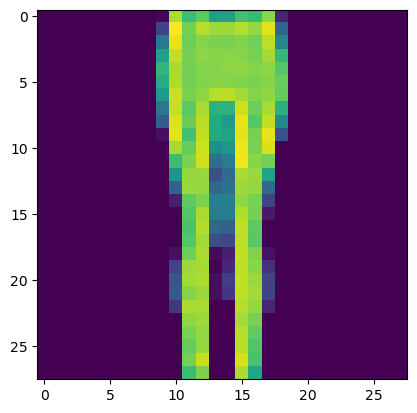

In [9]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap='viridis')

## 4. 定义网络
---

In [10]:
class FMNet(nn.Module):
    def __init__(self):
        super(FMNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        return x

model = FMNet()
model = model.cuda()

## 5. 选择损失函数

In [24]:
criterion = nn.CrossEntropyLoss(reduction='sum')

## 6. 选择优化器

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 7. 训练和验证模型

In [26]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    correct_num = 0
    total_num = 0
    
    # 遍历训练数据
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda() # 将数据和标签挪到GPU
        optimizer.zero_grad() # 梯度清理
        output = model(data) # 前向传播
        loss = criterion(output, label) # 计算损失，也就是预测结果和真实标签的误差
        loss.backward() # 反向传播，计算梯度
        optimizer.step() # 更新一步参数
        
        train_loss += loss.item() #计算损失
        preds = torch.argmax(output, dim=1)
        correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
        total_num += data.size(0) # 总预测数量
    train_loss = train_loss/len(train_loader.dataset) # 计算平均训练损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tTraining Loss:{train_loss:.6f}, Accuracy:{accuracy:.6f}') # 输出信息

In [27]:
# 定义验证函数并初始化
def evaluate(epoch): 
    model.eval() # 验证模式
    evaluate_loss = 0 #累积验证损失
    correct_num = 0 
    total_num = 0 
    
    # 禁用梯度
    with torch.no_grad():
        # 遍历测试数据
        for data, label in test_loader: 
            data, label = data.cuda(), label.cuda() #数据迁移到GPU
            output = model(data) # 前向传播
            loss = criterion(output, label) # 计算当前批次损失
            
            evaluate_loss += loss.item() # 累积总损失
            preds = torch.argmax(output, dim=1) # 取得每行最大值的索引，获取预测结果。
            correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
            total_num += data.size(0) # 总预测数量
    evaluate_loss = evaluate_loss/total_num # 计算平均验证损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tValidation Loss:{evaluate_loss:.6f}, Accuracy:{accuracy:.6f}') #打印输出信息

In [28]:
for epoch in range(1, 2):
    train(epoch)
    evaluate(epoch)

Epoch:1	Training Loss:0.178590, Accuracy:0.932626
Epoch:1	Validation Loss:0.233968, Accuracy:0.916600


## 8. 保存模型

In [23]:
model_path = './model_pkl/FashionModel.pkl'
torch.save(model, model_path)
torch.save(model.state_dict, model_path)